# A Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import tensorflow as tf
import tensorflow_addons as tfa
from os.path import join as osj
import pandas as pd

from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, Dense, Bidirectional, Input
from tensorflow.keras import Model

import random
import pickle
import time
import os
import argparse

from datetime import datetime
from sklearn.metrics import confusion_matrix
from  sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger()

random.seed(654)


2025-03-29 13:21:08.741699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743254468.896601 1816108 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743254468.940172 1816108 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 13:21:09.338230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rbeck1_sw/inter-intra-patient/venv_tf/lib/python3.12/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarni

# B Processing steps

## Functions

In [2]:
# F1 Read .mat files
def read_mitbih(filename, max_time=100, classes=['F', 'N', 'S', 'V', 'Q'], max_label=100):

    random.seed(654)
    beats = [] 
    dict_samples = spio.loadmat(filename + '.mat')

    # header = dict_samples['__header__']
    # version = dict_samples['__version__']
    # globals = dict_samples['__globals__'] 
    samples = dict_samples['s2s_mitbih'] # 2D array with 2 columns: ecg values and labels
    values = samples[0]['seg_values'] # ecg values
    labels = samples[0]['seg_labels'] # labels

    # calculate the number of annotations and sequences
    num_annots = sum([item.shape[0] for item in values]) # 109338
    n_seqs = num_annots / max_time # 1093.38

    # add all beats together
    count_b = 0
    nr_recordings = [] # number of recordings per patient (each recording contains 280 measurements)
    for _, item in enumerate(values):
        l = item.shape[0] # number of recordings per patient (each recording contains 280 measurements)
        nr_recordings.append(l)
        for itm in item:
            if count_b == num_annots: # hence all recordings have been added
                break
            beats.append(itm[0]) # itm is one recording, with 280 measurements
            count_b += 1

    # add all labels together
    count_l  = 0
    t_labels = []
    for _, item in enumerate(labels): 
        if len(t_labels) == num_annots: # break if all labels have been added
            break
        item = item[0]
        # iterate over all recordings per patient
        for lbl in item: 
            if count_l == num_annots: # break if all labels have been added
                break
            t_labels.append(str(lbl))
            count_l += 1
    
    del values
    # convert list to array & reshape
    beats = np.asarray(beats)
    t_labels = np.asarray(t_labels)  
    shape_v = beats.shape # 109338 rows with each 280 entries (109338, 280, 1)
    beats = np.reshape(beats, [shape_v[0], -1]) # new shape = (109338, 280)


    # Create empty arrays for data and labels
    random_beats  = np.asarray([],dtype=np.float64).reshape(0,shape_v[1])
    random_labels = np.asarray([],dtype=np.dtype('|S1')).reshape(0,)

    # iterate over all classes and truncate to max_label samples, so that all classes are equally represented
    for cl in classes:
        _label = np.where(t_labels == cl) # select indices that match the class
        logger.info(f"Class {cl} is represented {len(_label[0])}")

        # random permutation of indices
        permute = np.random.permutation(len(_label[0])) 
        _label = _label[0][permute[:max_label]] # choose the first X indices
        logger.info(f"Class {cl} is now represented {len(_label)}")

        random_beats = np.concatenate((random_beats, beats[_label]))
        random_labels = np.concatenate((random_labels, t_labels[_label]))

    # shorten data to multiple of max_time
    signals = random_beats[:int(len(random_beats)/ max_time) * max_time, :]
    _labels  = random_labels[:int(len(random_beats) / max_time) * max_time]

    #  reshape data into groups of max_time
    data   = [signals[i:i + max_time] for i in range(0, len(signals), max_time)]
    labels = [_labels[i:i + max_time] for i in range(0, len(_labels), max_time)]

    permute = np.random.permutation(len(labels)) # random permutation of indices only

    # transform from list to array
    data   = np.asarray(data, dtype=object) 
    labels = np.asarray(labels, dtype=object)

    # reorder data and labels according to random permute
    data   = data[permute]
    labels = labels[permute]

    logger.info('Signals and labels processed!')

    return data, labels

# F2 Normaliza data
def normalize(data):
        data = np.nan_to_num(data)  # removing NaNs and Infs
        data = data - np.mean(data)
        data = data / np.std(data)
        return data

# F3 shuffle
def batch_data(x, y, batch_size):
    shuffle = np.random.permutation(len(x))
    start = 0
    #     from IPython.core.debugger import Tracer; Tracer()()
    x = x[shuffle]
    y = y[shuffle]
    while start + batch_size <= len(x):
        yield x[start:start + batch_size], y[start:start + batch_size]
        start += batch_size

# F4 bool value check
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

# def count_prameters():
    # logger.info(f"# of Params: {np.sum([np.prod(v.get_shape().as_list()) for v in tf.compat.v1.trainable_variables()])}")


In [ ]:
# F5 calculate performance
def evaluate_metrics(confusion_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    # F1 Score (Harmonic Mean of Precision & Recall)
    F1 = 2 * (PPV * TPR) / (PPV + TPR)

    return ACC_macro, ACC, TPR, TNR, PPV, NPV, FPR, FNR, FDR, F1

# F6 Network
def build_network(inputs, dec_inputs, char2numY, n_channels=10, input_depth=280, num_units=128, max_time=10, bidirectional=False):
    # Reshape the inputs to match the Conv1D expected shape
    _inputs = tf.reshape(inputs, [-1, n_channels, int(input_depth / n_channels)])
    
    # Convolutional and MaxPooling layers
    conv1 = Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu')(_inputs)
    max_pool_1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv1)

    conv2 = Conv1D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu')(max_pool_1)
    max_pool_2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)

    conv3 = Conv1D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu')(max_pool_2)

    # Flatten the output of the Conv1D layers
    shape = conv3.shape.as_list()
    data_input_embed = tf.reshape(conv3, (-1, max_time, shape[1] * shape[2]))

    # Embedding for the decoder
    embed_size = 10
    output_embedding = tf.Variable(tf.random.uniform((len(char2numY), embed_size), -1.0, 1.0), name='dec_embedding')
    data_output_embed = tf.nn.embedding_lookup(params=output_embedding, ids=dec_inputs)

    # Encoder
    if not bidirectional:
        # Regular LSTM
        lstm_enc = LSTM(num_units, return_state=True)
        _, last_state_h, last_state_c = lstm_enc(data_input_embed)
        last_state = (last_state_c, last_state_h)
    else:
        # Bidirectional LSTM
        lstm_enc = Bidirectional(LSTM(num_units, return_state=True))
        _, forward_h, forward_c, backward_h, backward_c = lstm_enc(data_input_embed)
        last_state_c = tf.concat([forward_c, backward_c], axis=-1)
        last_state_h = tf.concat([forward_h, backward_h], axis=-1)
        last_state = (last_state_c, last_state_h)

    # Decoder
    if not bidirectional:
        lstm_dec = LSTM(num_units, return_sequences=True)
    else:
        lstm_dec = LSTM(2 * num_units, return_sequences=True)

    dec_outputs = lstm_dec(data_output_embed, initial_state=last_state)

    # Final Dense layer to produce logits
    logits = Dense(len(char2numY))(dec_outputs)

    return logits


# # 7 configure biRNN
# def build_network(inputs, dec_inputs,char2numY,n_channels=10,input_depth=280,num_units=128,max_time=10,bidirectional=False):
#     _inputs = tf.reshape(inputs, [-1, n_channels, int(input_depth / n_channels)])
#     # _inputs = tf.reshape(inputs, [-1,input_depth,n_channels])

#     # #(batch*max_time, 280, 1) --> (N, 280, 18)
#     conv1 = tf.compat.v1.layers.conv1d(inputs=_inputs, filters=32, kernel_size=2, strides=1,
#                              padding='same', activation=tf.nn.relu)
#     max_pool_1 = tf.compat.v1.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

#     conv2 = tf.compat.v1.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1,
#                              padding='same', activation=tf.nn.relu)
#     max_pool_2 = tf.compat.v1.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')

#     conv3 = tf.compat.v1.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1,
#                              padding='same', activation=tf.nn.relu)

#     shape = conv3.get_shape().as_list()
#     data_input_embed = tf.reshape(conv3, (-1, max_time, shape[1] * shape[2]))

#     embed_size = 10  # 128 lstm_size # shape[1]*shape[2]

#     # Embedding layers
#     output_embedding = tf.Variable(tf.random.uniform((len(char2numY), embed_size), -1.0, 1.0), name='dec_embedding')
#     data_output_embed = tf.nn.embedding_lookup(params=output_embedding, ids=dec_inputs)

#     with tf.compat.v1.variable_scope("encoding") as encoding_scope:
#         if not bidirectional:

#             # Regular approach with LSTM units
#             lstm_enc = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units)
#             _, last_state = tf.compat.v1.nn.dynamic_rnn(lstm_enc, inputs=data_input_embed, dtype=tf.float32)

#         else:

#             # Using a bidirectional LSTM architecture instead
#             enc_fw_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units)
#             enc_bw_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units)

#             ((enc_fw_out, enc_bw_out), (enc_fw_final, enc_bw_final)) = tf.compat.v1.nn.bidirectional_dynamic_rnn(
#                 cell_fw=enc_fw_cell,
#                 cell_bw=enc_bw_cell,
#                 inputs=data_input_embed,
#                 dtype=tf.float32)
#             enc_fin_c = tf.concat((enc_fw_final.c, enc_bw_final.c), 1)
#             enc_fin_h = tf.concat((enc_fw_final.h, enc_bw_final.h), 1)
#             last_state = tf.nn.rnn_cell.LSTMStateTuple(c=enc_fin_c, h=enc_fin_h)

#     with tf.compat.v1.variable_scope("decoding") as decoding_scope:
#         if not bidirectional:
#             lstm_dec = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units)
#         else:
#             lstm_dec = tf.compat.v1.nn.rnn_cell.LSTMCell(2 * num_units)

#         dec_outputs, _ = tf.compat.v1.nn.dynamic_rnn(lstm_dec, inputs=data_output_embed, initial_state=last_state)

#     logits = tf.compat.v1.layers.dense(dec_outputs, units=len(char2numY), use_bias=True)

#     return logits

# 7 Model evaluation
def test_model(sess, logits, X_test, y_test, batch_size, char2numY, y_seq_length, n_classes, inputs, dec_inputs):
    # source_batch, target_batch = next(batch_data(X_test, y_test, batch_size))
    acc_track = []
    sum_test_conf = []
    count = 0
    for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_test, y_test, batch_size)):
        logger.info(f"Running batch: {count}")
        count = count + 1
        dec_input = np.zeros((len(source_batch), 1)) + char2numY['<GO>']

        for i in range(y_seq_length):
            batch_logits = sess.run(logits, feed_dict={inputs: source_batch, dec_inputs: dec_input})
            prediction = batch_logits[:, -1].argmax(axis=-1)
            dec_input = np.hstack([dec_input, prediction[:, None]])

        acc_track.append(dec_input[:, 1:] == target_batch[:, 1:])
        y_true= target_batch[:, 1:].flatten()
        y_pred = dec_input[:, 1:].flatten()
        sum_test_conf.append(confusion_matrix(y_true, y_pred,labels=list(range(len(char2numY)-1))))

    sum_test_conf= np.mean(np.array(sum_test_conf, dtype=np.float32), axis=0)
    acc_avg, acc, sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score= evaluate_metrics(sum_test_conf)

    logger.info(f"Average Accuracy is: {acc_avg} on test set")

    for idx in range(n_classes):
        logger.info(f"\t{classes[idx]} rhythm -> Sensitivity: {sensitivity[idx]}, Specificity : {specificity[idx]}, Precision (PPV) : {ppv[idx]}, Accuracy : {acc[idx]}")

    logger.info(f"\t Average -> Sensitivity: {np.mean(sensitivity)}, Specificity : {np.mean(specificity)}, Precision (PPV) : {np.mean(ppv)}, Accuracy : {np.mean(acc)}")
    
    return acc_avg, acc, sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score


## Program

In [8]:
# def run_program(args):
def run_program(epochs, max_time, test_steps, batch_size, data_dir, bidirectional, num_units,
            n_oversampling, checkpoint_dir, ckpt_name, classes):
    
    # # Arguments
    # logger.info(args)
    # max_time = args.max_time # 5 3 second best 10# 40 # 100
    # epochs = args.epochs # 300
    # batch_size = args.batch_size # 10
    # num_units = args.num_units
    # bidirectional = args.bidirectional
    # # lstm_layers = args.lstm_layers
    # n_oversampling = args.n_oversampling
    # checkpoint_dir = args.checkpoint_dir
    # ckpt_name = args.ckpt_name
    # test_steps = args.test_steps
    # classes= args.classes
    # filename = args.data_dir
    filename = data_dir

    n_channels = 10

    # STEP 1 Read .mat data
    X, Y = read_mitbih(filename,max_time,classes=classes,max_label=100000)
    input_depth = X.shape[2]
    classes = np.unique(Y)
    char2numY = dict(list(zip(classes, list(range(len(classes))))))
    n_classes = len(classes)

    logger.info(f"Sequences: {len(X)}")
    logger.info(f"Classes: {classes}")

    for cl in classes:
        ind = np.where(classes == cl)[0][0]
        logger.info(f"Class: {cl} - count: {len(np.where(Y.flatten() == cl)[0])}")

    char2numY['<GO>'] = len(char2numY)
    num2charY = dict(list(zip(list(char2numY.values()), list(char2numY.keys()))))

    Y = [[char2numY['<GO>']] + [char2numY[y_] for y_ in date] for date in Y]
    Y = np.array(Y)

    x_seq_length = len(X[0])
    y_seq_length = len(Y[0])- 1

    # Placeholders
    tf.compat.v1.disable_eager_execution()
    inputs = tf.compat.v1.placeholder(tf.float32, [None, max_time, input_depth], name = 'inputs')
    targets = tf.compat.v1.placeholder(tf.int32, (None, None), 'targets')
    dec_inputs = tf.compat.v1.placeholder(tf.int32, (None, None), 'output')

    logits = build_network(inputs, dec_inputs, char2numY, n_channels=n_channels, input_depth=input_depth, num_units=num_units, max_time=max_time,
                  bidirectional=bidirectional)
    # decoder_prediction = tf.argmax(logits, 2)
    # confusion = tf.confusion_matrix(labels=tf.argmax(targets, 1), predictions=tf.argmax(logits, 2), num_classes=len(char2numY) - 1)# it is wrong
    # mean_accuracy,update_mean_accuracy = tf.metrics.mean_per_class_accuracy(labels=targets, predictions=decoder_prediction, num_classes=len(char2numY) - 1)

    with tf.compat.v1.name_scope("optimization"):
        # Loss function
        vars = tf.compat.v1.trainable_variables()
        beta = 0.001
        lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in vars if 'bias' not in v.name]) * beta
        loss = tfa.seq2seq.sequence_loss(logits, targets, tf.ones([batch_size, y_seq_length]))
        loss = tf.reduce_mean(input_tensor=loss + lossL2)
         # Optimizer
        optimizer = tf.compat.v1.train.RMSPropOptimizer(1e-3).minimize(loss)


    # split the dataset into the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # over-sampling: SMOTE
    X_train = np.reshape(X_train,[X_train.shape[0]*X_train.shape[1],-1])
    y_train= y_train[:,1:].flatten()

    nums = []
    for cl in classes:
        ind = np.where(classes == cl)[0][0]
        nums.append(len(np.where(y_train.flatten()==ind)[0]))

    # ratio={0:nums[3],1:nums[1],2:nums[3],3:nums[3]} # the best with 11000 for N
    ratio={0:n_oversampling,1:nums[1],2:n_oversampling,3:n_oversampling}
    # Fixed by me: https://stackoverflow.com/questions/62225793/typeerror-init-got-an-unexpected-keyword-argument-ratio-when-using-smot
    # version with error: sm = SMOTE(random_state=12,ratio=ratio)
    sm = SMOTE(random_state=12,sampling_strategy=ratio)
    # Fixed by me: https://stackoverflow.com/questions/66364406/attributeerror-smote-object-has-no-attribute-fit-sample
    # version with error: X_train, y_train = sm.fit_sample(X_train, y_train)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    X_train = X_train[:int(X_train.shape[0]/max_time)*max_time,:]
    y_train = y_train[:int(X_train.shape[0]/max_time)*max_time]

    X_train = np.reshape(X_train,[-1,X_test.shape[1],X_test.shape[2]])
    y_train = np.reshape(y_train,[-1,y_test.shape[1]-1,])

    y_train= [[char2numY['<GO>']] + [y_ for y_ in date] for date in y_train]
    y_train = np.array(y_train)

    # Logging instead of prints (Ricarda)
    logger.info(f"Classes in the training set: {classes}")
    for cl in classes:
        ind = np.where(classes == cl)[0][0]
        logger.info(f"Class: {cl}, Count: {len(np.where(y_train.flatten() == ind)[0])}")

    logger.info("------------------ y_train samples --------------------")
    for ii in range(2):
        logger.info(''.join([num2charY[y_] for y_ in list(y_train[ii+5])]))

    logger.info(f"Classes in the test set: {classes}")
    for cl in classes:
        ind = np.where(classes == cl)[0][0]
        logger.info(f"Class: {cl}, Count: {len(np.where(y_test.flatten() == ind)[0])})")

    logger.info("------------------ y_test samples --------------------")
    for ii in range(2):
        logger.info(''.join([num2charY[y_] for y_ in list(y_test[ii+5])]))

    # moved to code instead of function (Ricarda)
    logger.info(f"# of Params: {np.sum([np.prod(v.get_shape().as_list()) for v in tf.compat.v1.trainable_variables()])}")

    if (os.path.exists(checkpoint_dir) == False):
        os.mkdir(checkpoint_dir)

    # train the graph
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(tf.compat.v1.local_variables_initializer())

        saver = tf.compat.v1.train.Saver()
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)

        test_results = {}
        # Restore if available
        if ckpt and ckpt.model_checkpoint_path:
            
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
            acc_avg, acc, sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = test_model(sess, logits, X_test, y_test, batch_size, char2numY, y_seq_length, n_classes, inputs, dec_inputs) # definition moved to function definitions (Ricarda)
            test_results["avg_acc"] = acc_avg
            test_results["acc"] = acc
            test_results["sens"] = sensitivity
            test_results["spec"] = specificity
            test_results["prec"] = ppv
            test_results["neg_pred_value"] = npv
            test_results["false_pos_rate"] = fpr
            test_results["false_neg_rate"] = fnr
            test_results["false_det_rate"] = fdr
            test_results["f1_score"]       = f1_score

            with open(osj("..", "results", "intrapatient", f"test_results.pkl"), "wb") as f:
                pickle.dump(test_results, f) 
        else:

            loss_track = []
            for epoch_i in range(epochs):
                start_time = time.time()
                train_acc = []
                for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_train, y_train, batch_size)):
                    _, batch_loss, batch_logits = sess.run([optimizer, loss, logits],
                        feed_dict = {inputs: source_batch,
                                     dec_inputs: target_batch[:, :-1],
                                     targets: target_batch[:, 1:]})
                    loss_track.append(batch_loss)
                    train_acc.append(batch_logits.argmax(axis=-1) == target_batch[:,1:])

                accuracy = np.mean(train_acc)
                logger.info(f"Epoch {epoch_i+1} Loss: {batch_loss} Accuracy: {accuracy} Epoch duration: {time.time() - start_time}s started at {start_time}")

                if epoch_i%test_steps==0:
                    acc_avg, acc, sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = test_model(sess, logits, X_test, y_test, batch_size, char2numY, y_seq_length, n_classes, inputs, dec_inputs) # definition moved to function definitions (Ricarda)
                    test_results["avg_acc"] = acc_avg
                    test_results["acc"] = acc
                    test_results["sens"] = sensitivity
                    test_results["spec"] = specificity
                    test_results["prec"] = ppv
                    test_results["neg_pred_value"] = npv
                    test_results["false_pos_rate"] = fpr
                    test_results["false_neg_rate"] = fnr
                    test_results["false_det_rate"] = fdr
                    test_results["f1_score"]       = f1_score
                    
                    with open(osj("..", "results", "intrapatient", f"test_results.pkl"), "wb") as f:
                        pickle.dump(test_results, f) 

                    logger.info(f"Loss {loss} after {epoch_i+1} epochs (batch_size={batch_size})")
                    save_path = os.path.join(checkpoint_dir, ckpt_name)
                    saver.save(sess, save_path)
                    logger.info(f"Model saved in path {save_path}")

            plt.plot(loss_track)
            plt.show()
        
        logger.info(f"Model training finished!")

## Manual run of program

2025-03-18 13:18:10 - INFO - Class F is represented 802
2025-03-18 13:18:10 - INFO - Class F is now represented 802
2025-03-18 13:18:10 - INFO - Class N is represented 90502
2025-03-18 13:18:10 - INFO - Class N is now represented 90502
2025-03-18 13:18:10 - INFO - Class S is represented 2777
2025-03-18 13:18:10 - INFO - Class S is now represented 2777
2025-03-18 13:18:10 - INFO - Class V is represented 7226
2025-03-18 13:18:10 - INFO - Class V is now represented 7226
2025-03-18 13:18:11 - INFO - Signals and labels processed!
2025-03-18 13:18:12 - INFO - Sequences: 10130
2025-03-18 13:18:12 - INFO - Classes: ['F' 'N' 'S' 'V']
2025-03-18 13:18:12 - INFO - Class: F - count: 802
2025-03-18 13:18:12 - INFO - Class: N - count: 90502
2025-03-18 13:18:12 - INFO - Class: S - count: 2777
2025-03-18 13:18:12 - INFO - Class: V - count: 7219
/home/rbeck1_sw/inter-intra-patient/venv_tf/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.

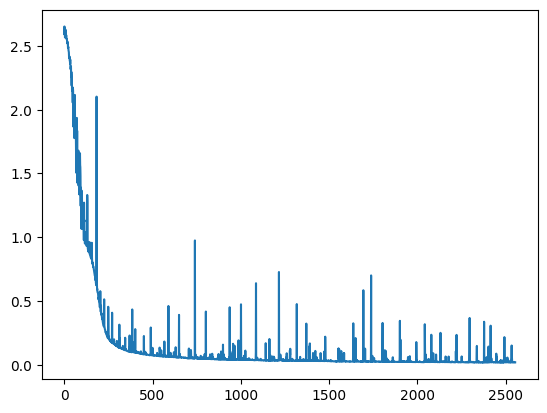

2025-03-18 13:18:31 - INFO - Model training finished!


In [ ]:
epochs         = 5
max_time       = 10
test_steps     = 10
batch_size     = 20
data_dir       = '../data/s2s_mitbih_aami'
# data_dir       = '../datapreprocessing_Matlab/s2s_mitbih_aami' # processed manually
bidirectional  = False
# lstm_layers    = 2
num_units      = 128
n_oversampling = 10000
checkpoint_dir = 'checkpoints-seq2seq'
ckpt_name      = 'seq2seq_mitbih.ckpt'
classes        = ['F','N','S','V']

filename = data_dir
n_channels = 10

# STEP 1 Read .mat data
X, Y = read_mitbih(filename,max_time,classes=classes,max_label=100000)
input_depth = X.shape[2]
classes = np.unique(Y)
char2numY = dict(list(zip(classes, list(range(len(classes))))))
n_classes = len(classes)

logger.info(f"Sequences: {len(X)}")
logger.info(f"Classes: {classes}")

for cl in classes:
    ind = np.where(classes == cl)[0][0]
    logger.info(f"Class: {cl} - count: {len(np.where(Y.flatten() == cl)[0])}")

char2numY['<GO>'] = len(char2numY)
num2charY = dict(list(zip(list(char2numY.values()), list(char2numY.keys()))))

Y = [[char2numY['<GO>']] + [char2numY[y_] for y_ in date] for date in Y]
Y = np.array(Y)

x_seq_length = len(X[0])
y_seq_length = len(Y[0])- 1

# Step 2 Prepare network
tf.compat.v1.disable_eager_execution()
inputs = tf.compat.v1.placeholder(tf.float32, [None, max_time, input_depth], name = 'inputs')
targets = tf.compat.v1.placeholder(tf.int32, (None, None), 'targets')
dec_inputs = tf.compat.v1.placeholder(tf.int32, (None, None), 'output')

logits = build_network(inputs, dec_inputs, char2numY, n_channels=n_channels, input_depth=input_depth, num_units=num_units, max_time=max_time,
                bidirectional=bidirectional)


# STEP 3 Prepare the data for training
with tf.compat.v1.name_scope("optimization"):
    # Loss function
    vars = tf.compat.v1.trainable_variables()
    beta = 0.001
    lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in vars if 'bias' not in v.name]) * beta
    loss = tfa.seq2seq.sequence_loss(logits, targets, tf.ones([batch_size, y_seq_length]))
    loss = tf.reduce_mean(input_tensor=loss + lossL2)
        # Optimizer
    optimizer = tf.compat.v1.train.RMSPropOptimizer(1e-3).minimize(loss)


# split the dataset into the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# over-sampling: SMOTE
X_train = np.reshape(X_train,[X_train.shape[0]*X_train.shape[1],-1])
y_train= y_train[:,1:].flatten()

nums = []
for cl in classes:
    ind = np.where(classes == cl)[0][0]
    nums.append(len(np.where(y_train.flatten()==ind)[0]))

# ratio={0:nums[3],1:nums[1],2:nums[3],3:nums[3]} # the best with 11000 for N
ratio={0:n_oversampling,1:nums[1],2:n_oversampling,3:n_oversampling}
# Fixed by Ricarda: https://stackoverflow.com/questions/62225793/typeerror-init-got-an-unexpected-keyword-argument-ratio-when-using-smot
# version with error: sm = SMOTE(random_state=12,ratio=ratio)
sm = SMOTE(random_state=12,sampling_strategy=ratio)
# Fixed by Ricarda: https://stackoverflow.com/questions/66364406/attributeerror-smote-object-has-no-attribute-fit-sample
# version with error: X_train, y_train = sm.fit_sample(X_train, y_train)
X_train, y_train = sm.fit_resample(X_train, y_train)

X_train = X_train[:int(X_train.shape[0]/max_time)*max_time,:]
y_train = y_train[:int(X_train.shape[0]/max_time)*max_time]

X_train = np.reshape(X_train,[-1,X_test.shape[1],X_test.shape[2]])
y_train = np.reshape(y_train,[-1,y_test.shape[1]-1,])

y_train= [[char2numY['<GO>']] + [y_ for y_ in date] for date in y_train]
y_train = np.array(y_train)

logger.info(f"Classes in the training set: {classes}")
for cl in classes:
    ind = np.where(classes == cl)[0][0]
    logger.info(f"Class: {cl}, Count: {len(np.where(y_train.flatten() == ind)[0])}")

logger.info("------------------ y_train samples --------------------")
for ii in range(2):
    logger.info(''.join([num2charY[y_] for y_ in list(y_train[ii+5])]))

logger.info(f"Classes in the test set: {classes}")
for cl in classes:
    ind = np.where(classes == cl)[0][0]
    logger.info(f"Class: {cl}, Count: {len(np.where(y_test.flatten() == ind)[0])})")

logger.info("------------------ y_test samples --------------------")
for ii in range(2):
    logger.info(''.join([num2charY[y_] for y_ in list(y_test[ii+5])]))

# moved to code instead of function (Ricarda)
logger.info(f"# of Params: {np.sum([np.prod(v.get_shape().as_list()) for v in tf.compat.v1.trainable_variables()])}")

if (os.path.exists(checkpoint_dir) == False):
    os.mkdir(checkpoint_dir)

# Step 4: Train the graph
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.local_variables_initializer())

    saver = tf.compat.v1.train.Saver()
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)

    test_results = {}
    
    # Restore if available
    if ckpt and ckpt.model_checkpoint_path:
        
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
        acc_avg, acc, sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = test_model(sess, logits, X_test, y_test, batch_size, char2numY, y_seq_length, n_classes, inputs, dec_inputs) # definition moved to function definitions (Ricarda)
        test_results["avg_acc"] = acc_avg
        test_results["acc"] = acc
        test_results["sens"] = sensitivity
        test_results["spec"] = specificity
        test_results["prec"] = ppv
        test_results["neg_pred_value"] = npv
        test_results["false_pos_rate"] = fpr
        test_results["false_neg_rate"] = fnr
        test_results["false_det_rate"] = fdr
        test_results["f1_score"]       = f1_score

        with open(osj("..", "results", "intrapatient", f"test_results.pkl"), "wb") as f:
            pickle.dump(test_results, f) 
    else:

        loss_track = []
        for epoch_i in range(epochs):
            start_time = time.time()
            train_acc = []
            for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_train, y_train, batch_size)):
                _, batch_loss, batch_logits = sess.run([optimizer, loss, logits],
                    feed_dict = {inputs: source_batch,
                                    dec_inputs: target_batch[:, :-1],
                                    targets: target_batch[:, 1:]})
                loss_track.append(batch_loss)
                train_acc.append(batch_logits.argmax(axis=-1) == target_batch[:,1:])

            accuracy = np.mean(train_acc)
            logger.info(f"Epoch {epoch_i+1} Loss: {batch_loss} Accuracy: {accuracy} Epoch duration: {time.time() - start_time}s started at {start_time}")

            if epoch_i%test_steps==0:
                acc_avg, acc, sensitivity, specificity, ppv, npv, fpr, fnr, fdr, f1_score = test_model(sess, logits, X_test, y_test, batch_size, char2numY, y_seq_length, n_classes, inputs, dec_inputs) # definition moved to function definitions (Ricarda)
                test_results["avg_acc"] = acc_avg
                test_results["acc"] = acc
                test_results["sens"] = sensitivity
                test_results["spec"] = specificity
                test_results["prec"] = ppv
                test_results["neg_pred_value"] = npv
                test_results["false_pos_rate"] = fpr
                test_results["false_neg_rate"] = fnr
                test_results["false_det_rate"] = fdr
                test_results["f1_score"]       = f1_score
                
                with open(osj("..", "results", "intrapatient", f"test_results.pkl"), "wb") as f:
                    pickle.dump(test_results, f) 

                logger.info(f"Loss {loss} after {epoch_i+1} epochs (batch_size={batch_size})")
                save_path = os.path.join(checkpoint_dir, ckpt_name)
                saver.save(sess, save_path)
                logger.info(f"Model saved in path {save_path}")

        plt.plot(loss_track)
        plt.show()
    
    logger.info(f"Model training finished!")

In [4]:
epochs         = 5
max_time       = 10
test_steps     = 10
batch_size     = 20
data_dir       = '../data/s2s_mitbih_aami'
bidirectional  = False
num_units      = 128
n_oversampling = 10000
checkpoint_dir = 'checkpoints-seq2seq'
ckpt_name      = 'seq2seq_mitbih.ckpt'
classes        = ['F','N','S','V']

filename = data_dir
n_channels = 10

X, Y = read_mitbih(filename,max_time,classes=classes,max_label=100000)

2025-03-29 10:57:31 - INFO - Class F is represented 802
2025-03-29 10:57:31 - INFO - Class F is now represented 802
2025-03-29 10:57:31 - INFO - Class N is represented 90502
2025-03-29 10:57:31 - INFO - Class N is now represented 90502
2025-03-29 10:57:31 - INFO - Class S is represented 2777
2025-03-29 10:57:31 - INFO - Class S is now represented 2777
2025-03-29 10:57:31 - INFO - Class V is represented 7226
2025-03-29 10:57:31 - INFO - Class V is now represented 7226
2025-03-29 10:57:32 - INFO - Signals and labels processed!
